# Histograms, Differential Privacy and Bias

This Python notebook shows how differential privacy can magnify bias in simple
data queries like histograms. The notebook covers reading in data from a file,
preparing the data, computing a histogram, and observing issues with bias.

As a running example, let's generate a simple histogram of subpopulations in the
Diverse Communities Data Excerpts dataset curated by NIST and drawn from the US
Census Bureau's American Communities Survey (ACS).

## Step 1: Loading the Data

Before we start writing code, let's import a few third-party Pyhon packages. We
will use `pandas` for creating and manipulation data frames, `numpy` for basic
operations over vectorized datatypes, and `matplotlib` for visualizing results.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Our first step is to load the data. To do this we read the CSV file into a
dataframe object using `pandas`.

In [3]:
df = pd.read_csv('https://media.githubusercontent.com/media/usnistgov/SDNist/main/nist%20diverse%20communities%20data%20excerpts/massachusetts/ma2019.csv')

## Step 2: Preparing the Data

Let's display the data frame to get a sense for what the data looks like.

In [4]:
display(df)

,PUMA,AGEP,SEX,MSP,HISP,RAC1P,NOC,NPF,HOUSING_TYPE,OWN_RENT,...,PINCP,PINCP_DECILE,POVPIP,DVET,DREM,DPHY,DEYE,DEAR,PWGTP,WGTP
0,25-00503,18,1,6,0,1,N,N,3,0,...,5000.0,1,N,N,2,2,2,2,72,0
1,25-00703,21,2,6,0,1,N,N,3,0,...,0.0,0,N,N,2,2,2,2,6,0
2,25-00503,22,2,6,0,6,N,N,3,0,...,18000.0,3,N,N,2,2,2,2,80,0
3,25-01300,58,1,6,0,1,N,N,2,0,...,0.0,0,N,N,1,2,2,2,57,0
4,25-00703,18,2,6,0,1,N,N,3,0,...,3300.0,1,N,N,2,2,2,2,24,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7629,25-01300,8,1,N,0,1,2,3,1,1,...,N,N,501,N,2,2,2,2,45,41
7630,25-00703,14,1,N,0,1,1,3,1,1,...,N,N,501,N,2,2,2,2,115,114
7631,25-00503,3,1,N,0,6,2,4,1,1,...,N,N,347,N,N,N,2,2,69,75
7632,25-00503,1,2,N,0,6,2,4,1,1,...,N,N,347,N,N,N,2,2,64,75


As you can see, the data uses numeric codes for various attributes. We'd like to
create histogram plot of race category subpopulations, encoded as the `RAC1P`
column in the data. To make the results easier interpret, lets first convert
those numeric codes to textual descriptions.

In [5]:
dict_race = {
      1: "White",
      2: "Black or African American",
      3: "American Indian",
      4: "Alaska Native",
      5: "American Indian and Alaska Native tribes specified; or American Indian or Alaska Native, not specified and no other races",
      6: "Asian",
      7: "Native Hawaiian and Other Pacific Islander alone",
      8: "Some Other Race",
      9: "Two or More Races"
    }
df = df.replace({'RAC1P': dict_race})
display(df)

,PUMA,AGEP,SEX,MSP,HISP,RAC1P,NOC,NPF,HOUSING_TYPE,OWN_RENT,...,PINCP,PINCP_DECILE,POVPIP,DVET,DREM,DPHY,DEYE,DEAR,PWGTP,WGTP
0,25-00503,18,1,6,0,White,N,N,3,0,...,5000.0,1,N,N,2,2,2,2,72,0
1,25-00703,21,2,6,0,White,N,N,3,0,...,0.0,0,N,N,2,2,2,2,6,0
2,25-00503,22,2,6,0,Asian,N,N,3,0,...,18000.0,3,N,N,2,2,2,2,80,0
3,25-01300,58,1,6,0,White,N,N,2,0,...,0.0,0,N,N,1,2,2,2,57,0
4,25-00703,18,2,6,0,White,N,N,3,0,...,3300.0,1,N,N,2,2,2,2,24,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7629,25-01300,8,1,N,0,White,2,3,1,1,...,N,N,501,N,2,2,2,2,45,41
7630,25-00703,14,1,N,0,White,1,3,1,1,...,N,N,501,N,2,2,2,2,115,114
7631,25-00503,3,1,N,0,Asian,2,4,1,1,...,N,N,347,N,N,N,2,2,69,75
7632,25-00503,1,2,N,0,Asian,2,4,1,1,...,N,N,347,N,N,N,2,2,64,75


As you can see, the values in the `RAC1P` column of the data have been replaced
with textual descriptions.

## Step 3: Creating the Histogram

Next, let's focus our attention on a smaller region of the dataset. The `PUMA`
column in the data is an identifier for the geographical area where each person
is located, so let's focus on just that geographical area, group the
results by the race attribute, and then count the total number of people in each
group.

In [6]:
results = df[df['PUMA'] == '25-00503'].groupby('RAC1P').size().sort_values()
display(results)

RAC1P
American Indian                 1
Some Other Race                12
Black or African American      32
Two or More Races              52
Asian                         261
White                        1150
dtype: int64

## Step 4: Observing Issues with Bias

To make these query results differentially private we would add noise to each
subpopulation count with scale inversely proportional to the desired epsilon. To
characterize the effect this noise will have on the raw counts, let's compute
the 95% Confidence Interval (CI) for the result. The formula for this is
$-\ln(0.05)/\epsilon$. Let's calculate the 95% CI for $\epsilon=1$.

In [7]:
print(-np.log(0.05)/1)

2.995732273553991


Let's plot a histogram with error bars to visualize the distribution generated
by the differentially private result. In this plot, the histogram bar represents
the distribution's mean, and the error bars represent the distribution's 95% CI.

Note that this plot will be in *log scale*. This means instead of the axis
stepping between a linear sequence of values like 10, 20, 30, 40, etc., it will
instead step between exponentially increasing values like 1, 10, 100, 1000, etc.
In particular, notice that the error bars all represent the same range of
values, but the visual presentation of the error bar will look longer for low
y-axis values and shorter for high y-axis values.

Here is the plot for $\epsilon = 1$.

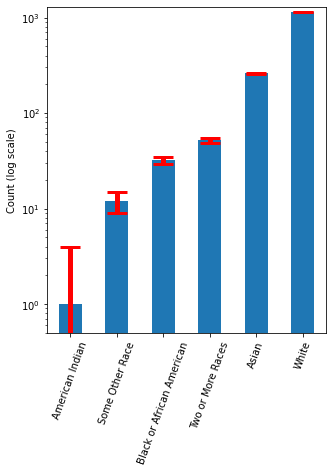

In [8]:
epsilon = 1
err_95 = -np.log(0.05)/epsilon

plt.figure(figsize=(5,6))
results.plot(
    kind='bar', 
    yerr=err_95, 
    error_kw=dict(ecolor='red', lw=5, capsize=10, capthick=3))
plt.xticks(rotation=70)
plt.yscale('log')
plt.xlabel('')
plt.ylabel('Count (log scale)')
plt.ylim((.5, 1300))
pass

As you can see, for minority populations like `American Indian`, the scale of
the noise (visualized by the 95% CI error bar) could result in a significant
over-counting or under-counting of that subpopulation with respect to the raw
counts. By contrast, for majority subpopulations like `White`, the scale of the
noise is negligible with respect to the raw count.

Let's generate a new plot for $\epsilon = 10$.

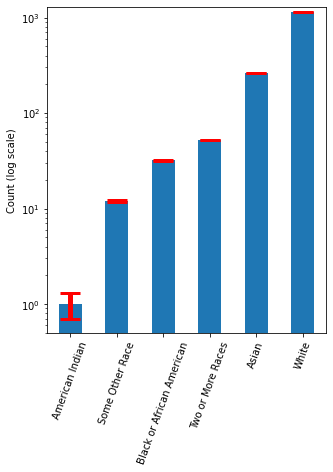

In [9]:
epsilon = 10
err_95 = -np.log(0.05)/epsilon

plt.figure(figsize=(5,6))
results.plot(
    kind='bar', 
    yerr=err_95, 
    error_kw=dict(ecolor='red', lw=5, capsize=10, capthick=3))
plt.xticks(rotation=70)
plt.yscale('log')
plt.xlabel('')
plt.ylabel('Count (log scale)')
plt.ylim((.5, 1300))
pass

As you can see, for higher epsilon values like $\epsilon = 10$ the magnitude of
the bias effect is reduced, but still present.